In [1]:
import xml.etree.ElementTree as ET
import os
import numpy as np

points_list = [] # list of point sequences
points_lengths = [] # list of lengths of point sequences

xmax = 0
ymax = 0

# Iterate through xml files
file_num = 0
folders = os.listdir('original')
for folder in folders:
    samples = os.listdir('original/' + folder)
    for sample in samples:
        file_num += 1
        tree = ET.parse('original/' + folder + '/' + sample + '/strokesz.xml')
        root = tree.getroot()

        # Save the x-y-EOS series as another numpy array, put it in list
        points = []
        for stroke in root.find('StrokeSet').findall('Stroke'):
            point_set = stroke.findall('Point')
            end = len(point_set) - 1
            for i, point in enumerate(point_set):
                x = float(point.get('x'))
                y = float(point.get('y'))
                
                xmax = max(xmax, x)
                ymax = max(ymax, y)
                eos = float(i == end)
                points.append([x, y, eos])
    point_series = np.array(points, dtype=np.float64)
    points_list.append(point_series)
    points_lengths.append(point_series.shape[0])
    
print('Done parsing')

Done parsing


In [2]:
import torch
import random

In [8]:
class GeneratorCell(torch.nn.Module):
    def __init__(self, hidden_size, mixture_size):
        super(GeneratorCell, self).__init__()

        self.gru = torch.nn.GRU(input_size=3, hidden_size=hidden_size, batch_first=True)
        self.hidden_size= hidden_size
        self.mixture_size = mixture_size

        # for generating mixture weights
        self.linear1 = torch.nn.Linear(hidden_size, mixture_size)

        # for generating means
        self.linear2 = torch.nn.Linear(hidden_size, 2*mixture_size) 
        
        # for generating standard deviations
        self.linear3 = torch.nn.Linear(hidden_size, 2*mixture_size) 

        # for generating correlations
        self.linear4 = torch.nn.Linear(hidden_size, mixture_size) 

        # for generating EOS probability
        self.linear5 = torch.nn.Linear(hidden_size, 1)

    def forward(self, input_batch, seq_lengths, max_length):
        input_batch = torch.nn.utils.rnn.pack_padded_sequence(input_batch, seq_lengths, batch_first=True) # not zero-padded
        output, hidden = self.gru(input_batch)
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True) # zero-padded
        
        mdn_input = torch.reshape(output, (-1, hidden_size))
        gmm_weights = torch.nn.functional.softmax(self.linear1(mdn_input), dim=1)
        
        # We treat the network's generated means as displacements from the previous position, so we add them
        # to the previous position to generate the next position's mean
        #input_batch, _ = torch.nn.utils.rnn.pad_packed_sequence(input_batch, batch_first=True) # zero-padded
        #x_for_adding = torch.reshape(input_batch[:, :, 0], (-1, 1)).repeat(1, self.mixture_size)
        #y_for_adding = torch.reshape(input_batch[:, :, 1], (-1, 1)).repeat(1, self.mixture_size)
        gmm_means = torch.exp(self.linear2(mdn_input))# + torch.cat((x_for_adding, y_for_adding), dim=1)
        gmm_stds = torch.exp(self.linear3(mdn_input))
        gmm_corrs = torch.tanh(self.linear4(mdn_input))
        eos_prob = torch.sigmoid(self.linear5(mdn_input))
        mdn_output = torch.cat((gmm_weights, gmm_means, gmm_stds, gmm_corrs, eos_prob), 1)
            
        return mdn_output
    
    # Given some (x, y, EOS), return the distribution parameters for the next (x, y, EOS) and the next hidden state
    def get_next(self, input, hidden):
        output, hidden = self.gru(input.view(1, 1, 3), hidden)
        
        # get rid of sequence index in output
        output = output.squeeze(1)

        gmm_weights = torch.nn.functional.softmax(self.linear1(output), dim=1)
        input_for_adding = torch.cat((input[0].repeat(1, self.mixture_size), input[1].repeat(1, self.mixture_size)), dim=1)
        gmm_means = torch.exp(self.linear2(output)) + input_for_adding
        gmm_stds = torch.exp(self.linear3(output))
        gmm_corrs = torch.tanh(self.linear4(output))
        eos_prob = torch.sigmoid(self.linear5(output))
        mdn_output = torch.cat((gmm_weights, gmm_means, gmm_stds, gmm_corrs, eos_prob), 1)
            
        return mdn_output, hidden

In [76]:
# seq_lengths tells us where to select the output to account for zero padding
def log_likelihood_batched(input_batch, output_batch, mixture_size, seq_lengths, max_length):
    input_batch = torch.reshape(input_batch, (-1, 3))
    
    # selection mask containing ones at any indices where output isn't padded
    output_length = max_length*len(seq_lengths)
    selection = torch.zeros((output_length), dtype=torch.bool)
    for i, length in enumerate(seq_lengths):
        start_index = i*max_length
        selection[start_index:(start_index + length)] = torch.ones((length), dtype=torch.bool)
        
    input_batch = input_batch[selection]
    output_batch = output_batch[selection]
    
    output_length = sum(seq_lengths)
    
    # iterate through Gaussians in mixture model
    prob = torch.zeros((output_length), dtype=torch.double)
    for k in range(mixture_size):
        # mixing coefficient lambda_k
        lambda_k = output_batch[:, k]

        mu_x = output_batch[:, mixture_size + k]
        mu_y = output_batch[:, 2*mixture_size + k]

        loc = torch.stack([mu_x, mu_y]).view(-1, 2) #for passing to multivariate normal
        sigma_x = output_batch[:, 3*mixture_size + k]
        sigma_y = output_batch[:, 4*mixture_size + k]
        correlation = output_batch[:, 5*mixture_size + k]

        cov = correlation*sigma_x*sigma_y
        cov_mat = torch.zeros((output_length, 2, 2), dtype=torch.double)
        cov_mat[:, 0, 0] = sigma_x**2
        cov_mat[:, 0, 1] = cov
        cov_mat[:, 1, 0] = cov
        cov_mat[:, 1, 1] = sigma_y**2

        gaussian = torch.distributions.multivariate_normal.MultivariateNormal(loc, cov_mat)
        prob += lambda_k*torch.exp(gaussian.log_prob(input_batch[:, 0:2]))

    # mean log probability of input data
    logprob = torch.sum(torch.log(prob + 0.0001*torch.ones((output_length))))
    eos = input_batch[:, 2]
    not_eos = torch.ones((output_length)) - eos
    logprob = logprob + torch.sum(eos*torch.log(output_batch[:, 6*mixture_size]) + not_eos*torch.log(1 - output_batch[:, 6*mixture_size]))
            
    return logprob/output_length

In [93]:
# Training loop
n_epochs = 50
n_iters = 50
hidden_size = 18
mixture_size = 3
batch_size = 10

model = GeneratorCell(hidden_size, mixture_size).double()

In [94]:
model.load_state_dict(torch.load('trained_model.pth'))

<All keys matched successfully>

In [95]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = np.zeros(n_epochs) # For plotting

indices = list(range(len(points_list))) # Indices for random sampling (for batches)

In [96]:
try:
    for epoch in range(n_epochs):
        for iter in range(n_iters):
            print('Epoch: ' + str(epoch) + ' Iteration: ' + str(iter))
            index_list = random.sample(indices, batch_size) # random sampling of indices
            seq_lengths = [points_lengths[i] for i in index_list] # list of sequence lengths

            # sort for padding
            batch_indices = [i for i, length in sorted(enumerate(seq_lengths), reverse=True, key=lambda x: x[1])]
            seq_lengths = [seq_lengths[i] - 1 for i in batch_indices]
            index_list = [index_list[i] for i in batch_indices]

            max_length = max(seq_lengths)
            input_batch = torch.zeros((batch_size, max_length + 1, 3), dtype=torch.double) # zero-padded
            for batch in range(batch_size):
                i = index_list[batch]
                input_batch[batch, 0:(seq_lengths[batch] + 1), :] = torch.from_numpy(points_list[i])
            input_batch = torch.autograd.Variable(input_batch)

            output_batch = model.forward(input_batch, seq_lengths, max_length)

            optimizer.zero_grad()
            loss = -log_likelihood_batched(input_batch[:, 1:, :], output_batch, mixture_size, seq_lengths, max_length)
            loss.backward()
            optimizer.step()

            print('Loss: ' + str(loss.data))

            losses[epoch] += loss.data
except KeyboardInterrupt:
    torch.save(model.state_dict(), 'trained_model.pth')

Epoch: 0 Iteration: 0
Loss: tensor(9.3913, dtype=torch.float64)
Epoch: 0 Iteration: 1
Loss: tensor(9.3516, dtype=torch.float64)
Epoch: 0 Iteration: 2
Loss: tensor(9.3559, dtype=torch.float64)
Epoch: 0 Iteration: 3
Loss: tensor(9.3923, dtype=torch.float64)
Epoch: 0 Iteration: 4
Loss: tensor(9.3991, dtype=torch.float64)
Epoch: 0 Iteration: 5
Loss: tensor(9.3892, dtype=torch.float64)
Epoch: 0 Iteration: 6
Loss: tensor(9.3554, dtype=torch.float64)
Epoch: 0 Iteration: 7
Loss: tensor(9.3505, dtype=torch.float64)
Epoch: 0 Iteration: 8
Loss: tensor(9.3804, dtype=torch.float64)
Epoch: 0 Iteration: 9
Loss: tensor(9.3652, dtype=torch.float64)
Epoch: 0 Iteration: 10
Loss: tensor(9.3751, dtype=torch.float64)
Epoch: 0 Iteration: 11
Loss: tensor(9.3733, dtype=torch.float64)
Epoch: 0 Iteration: 12
Loss: tensor(9.3803, dtype=torch.float64)
Epoch: 0 Iteration: 13
Loss: tensor(9.4000, dtype=torch.float64)
Epoch: 0 Iteration: 14
Loss: tensor(9.3807, dtype=torch.float64)
Epoch: 0 Iteration: 15
Loss: tensor

In [ ]:
torch.save(model.state_dict(), 'trained_model.pth')

Next we have a plotter script to see what our model generates

In [97]:
import matplotlib.pyplot as plt

In [98]:
output_x = [895] # list of x outputs. this is the initial x
output_y = [992] # list of y outputs. this is the initial y
eos = 0 # does the previous output correspond to an eos
hidden = torch.zeros((1, 1, hidden_size), dtype=torch.double)
for i in range(200):
    input = torch.tensor([output_x[-1], output_y[-1], eos], dtype=torch.double)
    dist, hidden = model.get_next(input, hidden)
    dist = dist.squeeze(0)
    sample = torch.zeros(2, dtype=torch.double)
    for k in range(mixture_size):
        # mixing coefficient lambda_k
        lambda_k = dist[k]

        mu_x = dist[mixture_size + k]
        mu_y = dist[2*mixture_size + k]

        loc = torch.tensor([mu_x, mu_y]) #for passing to multivariate normal
        sigma_x = 10*dist[3*mixture_size + k]
        sigma_y = 10*dist[4*mixture_size + k]
        correlation = dist[5*mixture_size + k]

        cov = correlation*sigma_x*sigma_y
        cov_mat = torch.zeros((2, 2), dtype=torch.double)
        cov_mat[0, 0] = sigma_x**2
        cov_mat[0, 1] = cov
        cov_mat[1, 0] = cov
        cov_mat[1, 1] = sigma_y**2

        gaussian = torch.distributions.multivariate_normal.MultivariateNormal(loc, cov_mat)
        sample += lambda_k*gaussian.rsample()
    output_x.append(sample[0].data)
    output_y.append(sample[1].data)
    
    b = torch.distributions.Bernoulli(dist[6*mixture_size])
    eos = b.sample().data

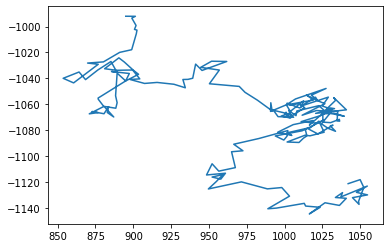

In [99]:
output_y = [-y for y in output_y]
plt.plot(output_x, output_y)

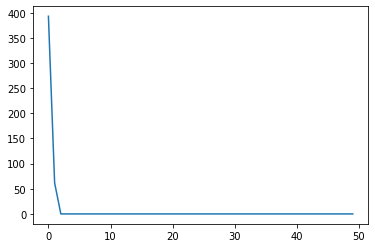

In [40]:
plt.plot(losses)
plt.show()